In [1]:
from __future__ import print_function
from firedrake import *
from firedrake_adjoint import *
import numpy as np
import os, sys
from firedrake import *
from firedrake_adjoint import *
import spyro
import numpy as np
import math

model = {}

# Choose method and parameters
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV", # Equi or KMV
    "degree": 1,  # p order
    "dimension": 2,  # dimension
}

# Number of cores for the shot. For simplicity, we keep things serial.
# spyro however supports both spatial parallelism and "shot" parallelism.
model["parallelism"] = {
    "type": "off",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    # input is a list of integers with the length of the number of shots.
}

# Define the domain size without the PML. Here we'll assume a 0.75 x 1.50 km
# domain and reserve the remaining 250 m for the Perfectly Matched Layer (PML) to absorb
# outgoing waves on three sides (eg., -z, +-x sides) of the domain.
model["mesh"] = {
    "Lz": 0.75,  # depth in km - always positive
    "Lx": 1.5,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "not_used.hdf5",
}

# Specify a 250-m PML on the three sides of the domain to damp outgoing waves.
model["PML"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  #  None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.7,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.25,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.25,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}

# Create a source injection operator. Here we use a single source with a
# Ricker wavelet that has a peak frequency of 8 Hz injected at the center of the mesh.
# We also specify to record the solution at 101 microphones near the top of the domain.
# This transect of receivers is created with the helper function `create_transect`.
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 1,
    "source_pos": [(0.1, 0.5)],
    "frequency": 5.0,
    "delay": 1.0,
    "num_receivers": 100,
    "receiver_locations": spyro.create_transect(
        (0.2, 0.5), (0.2, 0.7), 1
    ),
}

# Simulate for 2.0 seconds.
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.,  # Final time for event
    "dt": 0.0008,  # timestep size
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 1,  # how frequently to save solution to RAM
}

num_rec = 100
model["acquisition"]["num_receivers"]
δs = np.linspace(0.1, 0.9, num_rec)
X, Y = np.meshgrid(0.2, δs)
xs = np.vstack((X.flatten(), Y.flatten())).T


In [2]:
mesh = RectangleMesh(100, 100, 1.0, 1.0)
# V    = FunctionSpace(mesh, family='CG', degree=2)
# Create the computational environment
comm = spyro.utils.mpi_init(model)

element = spyro.domains.space.FE_method(
    mesh, model["opts"]["method"], model["opts"]["degree"]
)
V = FunctionSpace(mesh, element)


In [3]:
x, y = SpatialCoordinate(mesh)
velocity = conditional(x > 0.5, 1.5, 1.5)

# vp = Function(V, name="vp").interpolate(velocity)
m0 = Function(V, name="m0").interpolate(1/(velocity*velocity))


In [4]:
bcval = Constant(0.0)
def delta_expr(x0, z, xm, sigma_x):
    
    return exp(-sigma_x * ((z - x0[0]) ** 2 + (x - x0[1]) ** 2))

def timedependentSource(model, t, freq=None, amp=1, delay=1.5):
    if model["acquisition"]["source_type"] == "Ricker":
        return RickerWavelet(t, freq, amp, delay=delay)
    elif model["acquisition"]["source_type"] == "MMS":
        return MMS_time(t)
    else:
        raise ValueError("source not implemented")


def RickerWavelet(t, freq, amp=1.0, delay=1.5):
    """Creates a Ricker source function with a
    delay in term of multiples of the distance
    between the minimums.
    """
    t = t - delay * math.sqrt(6.0) / (math.pi * freq)
    return (
        amp
        * (1.0 - (1.0 / 2.0) * (2.0 * math.pi * freq) * (2.0 * math.pi * freq) * t * t)
        * math.exp(
            (-1.0 / 4.0) * (2.0 * math.pi * freq) * (2.0 * math.pi * freq) * t * t
        )
    )


def FullRickerWavelet(dt, tf, freq, amp=1.0, cutoff=None):
    """Compute the full Ricker wavelet and apply low-pass filtering
    using cutoff frequency in hz
    """
    nt = int(tf / dt)  # number of timesteps
    time = 0.0
    FullWavelet = np.zeros((nt,))
    for t in range(nt):
        FullWavelet[t] = RickerWavelet(time, freq, amp)
        time += dt
    if cutoff is not None:
        fs = 1.0 / dt
        order = 2
        nyq = 0.5 * fs  # Nyquist Frequency
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients
        b, a = butter(order, normal_cutoff, btype="low", analog=False)
        FullWavelet = filtfilt(b, a, FullWavelet)
    return FullWavelet


In [5]:
dim    = 2
amp    = 1
freq   = model["acquisition"]["frequency"]
method = model["opts"]["method"]
degree = model["opts"]["degree"]
dt     = model["timeaxis"]["dt"]
tf     = model["timeaxis"]["tf"]
delay  = model["acquisition"]["delay"]
nspool = model["timeaxis"]["nspool"]
fspool = model["timeaxis"]["fspool"]
# params = {"ksp_type": "preonly", "pc_type": "jacobi"}
params = {"ksp_type": "cg", "pc_type": "jacobi"}

qr_x, qr_s, _ = spyro.domains.quadrature.quadrature_rules(V)

source_num = 0


In [6]:
RW = FullRickerWavelet(dt, tf, freq, amp=amp, cutoff=None)
z, x = SpatialCoordinate(mesh)
sigma_x = Constant(2000)
pos = model["acquisition"]["source_pos"]

source = Constant(pos[source_num])
delta = Interpolator(delta_expr(source, z, x, sigma_x), V)
excitation = Function(delta.interpolate())

ricker = Constant(0)
f = excitation * ricker
ricker.assign(RW[0], annotate=True)

Constant(FiniteElement('Real', None, 0), 25)

In [7]:
from numpy import pi as π
from firedrake.assemble import create_assembly_callable
set_log_level(ERROR)

nt = int(tf / dt)  # number of timesteps
dstep = int(delay / dt)  # number of timesteps with source

u     = TrialFunction(V)
v     = TestFunction(V)
u_nm1 = Function(V,name="u_nm1")
u_n   = Function(V,name="u_n")
u_np1 = Function(V,name="u_np1")

# # -------------------------------------------------------
m1 = ((u - 2.0 * u_n + u_nm1) / Constant(dt ** 2)) * v * dx(rule=qr_x)
a  = (1/m0) * dot(grad(u_n), grad(v)) * dx(rule=qr_x)  # explicit

FF = m1 + a - (1/m0)*f * v * dx(rule=qr_x)

X = Function(V)
B = Function(V)

lhs_ = lhs(FF)
rhs_ = rhs(FF)
#----------------------------------------------------
# A      = assemble(lhs_, diagonal=True)
# solver = LinearSolver(A, solver_parameters=params)
# #----------------------------------------------------
# assembly_callable = create_assembly_callable(rhs_, tensor=B)
u = Function(V, name="u")
usol_recv = []
obj  = 0
t    = 0.0
step = 0

point_cloud = VertexOnlyMesh(mesh, xs)
P           = FunctionSpace(point_cloud, 'DG', 0)

problem = LinearVariationalProblem(lhs_, rhs_, u)
solver  = LinearVariationalSolver(problem, solver_parameters=params)

for IT in range(nt):
    
    step += 1
    if step < dstep:
        ricker.assign(RW[step])
    elif step == dstep:
        ricker.assign(0.0)

#     solve(lhs_ == rhs_, u, solver_parameters=params)
    solver.solve()
#     solver.solve(X, B)

    u_np1.assign(u)
    u_nm1.assign(u_n)
    u_n.assign(u_np1)

    rec  = interpolate(u_np1, P)
    usol_recv.append(rec.dat.data)
    if step<nt:
        obj += assemble(0.5*rec*dx)
        
    t   += dt
    

In [8]:
print(nt)
print(obj)


1250
-0.008763538929668588


100


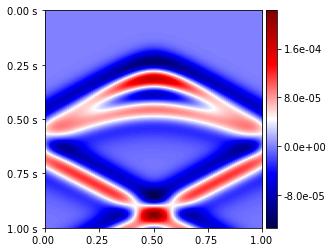

In [9]:
import numpy                  as np
import matplotlib.pyplot      as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm
from mpl_toolkits.axes_grid1  import make_axes_locatable
from matplotlib               import ticker
def graph2drec(rec):  
    print(len(rec[0]))
    
    tf     = model["timeaxis"]["tf"]
    extent = [0,1, tf, 0]
    fig    = plot.imshow(rec[:][:], cmap="seismic", extent=extent)
    plot.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f '))
    plot.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
    ax = plot.gca()
    ax.xaxis.set_major_locator(plot.MaxNLocator(4))
    ax.yaxis.set_major_locator(plot.MaxNLocator(4))
    
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    tick_locator = ticker.MaxNLocator(nbins=5)
    
    cbar = plot.colorbar(fig, cax=cax, format='%.1e')
    
    cbar.locator = tick_locator
    
    cbar.update_ticks()
    
    plot.draw()
     
    plot.show()
    plot.close()

    return
#==============================================================================

graph2drec(usol_recv)

In [10]:
control = Control(m0)
dJdm = compute_gradient(obj, control)


In [11]:
File("grad_ad.pvd").write(dJdm)